# Machine Learning and Statistics for Physicists

Material for a [UC Irvine](https://uci.edu/) course offered by the [Department of Physics and Astronomy](https://www.physics.uci.edu/).

Content is maintained on [github](github.com/dkirkby/MachineLearningStatistics) and distributed under a [BSD3 license](https://opensource.org/licenses/BSD-3-Clause).

[Table of contents](Contents.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
from sklearn import mixture

## Probability Theory

Probability theory is a mathematical language for reasoning about uncertain outcomes. Possible sources of uncertainty include:
 - Inherent randomness in a physical process, e.g., arising from [quantum phenomena](http://algassert.com/quirk#circuit={"cols":[]}) or a noisy measurement process.
 - Incomplete information, e.g., due to a measurement that only observes the partial state of a system or a model that only represents partial state.
 
Also, we sometimes chose to make an uncertain statement for convenience. For example, the statement **traveling faster than the speed of light is impossible** needs some unwieldy qualifiers to avoid any uncertainty, so it is convenient to instead state that **traveling faster than the speed of light is impossible under most circumstances**.

Probability theory enables us to build quantitative models that describe our data, both seen and not yet seen, so plays an important role in machine learning. A precise formulation is very technical since it must deal with edge cases that we never encounter in practical work. We will skip over most of the technical details here while still introducing the main concepts that are useful to understand the foundations of machine learning.

### Axioms of Probability

There are different (equally valid) approaches to formulating a theory of probability. Here we follow the approach of Kolmogorov based on set theory, which has three ingredients:
 1. A **sample space** $\Omega$ that defines the set of all possible uncertain outcomes.
 2. An **event space** $\cal F$ of combinations of outcomes (subsets of $\Omega$).
 3. A **probability measure** $P: {\cal F}\rightarrow [0,1]$ that assigns numerical probabilities to each event.
 
The tuple $(\Omega, {\cal F}, P)$ is a **probability space**.

For a concrete example, consider an electron with the following **probability space**:
 1. We are interested in a single electron that we can only observe via its spin. Therefore the **sample space** consists of its two possible spins: $\uparrow$ and $\downarrow$.
 2. Our **event space** consists of all subsets of the sample space: { }, {$\uparrow$}, {$\downarrow$}, {$\uparrow, \downarrow$}.
 3. Our **probability measure** assigns the probabilities: $P(\{\,\}) = 0$, $P(\{\uparrow\}) = P(\{\downarrow\}) = 0.5$, $P(\{\uparrow, \downarrow\}) = 1$.

A probability space defines an uncertain process that you can think of as a black box that generate outcomes $\omega_1, \omega_2, \ldots \in \Omega$. After each outcome $\omega_i$, all events containing $\omega_i$ are said to have **occurred** (so, in general, multiple events occur simultaneously).  Events $A, B, \ldots$ occur with probabilities $P(A), P(B), \ldots$, so the probability measure $P$ encodes the dynamics of the uncertain process.

Recall the basic operations of set theory that we will use frequently below. The box represents the set of all possible outcomes, $\Omega$, with individual outcomes $\omega$ indicated with dots. The labels show some possible subsets within the event space, constructed using the union ($\cup$), intersection ($\cap$) and complement ($\setminus$) operations (in logic, union and and intersection are called OR and AND):
![Set Theory Operations](img/Probability/SetOperations.png)

The choice of **sample space** is completely up to you and defines the "universe" you are considering. In the example, we decided to ignore the electron's position and momentum. Should the sample space for a coin toss include the possibility of the coin landing on its edge?  It is up to you.

The choice of **event space** is more constrained since it must satisfy the following conditions:
 - **R1:** If event $A$ is included, then so is its complement $\Omega \setminus A$. Therefore an event space containing {$\uparrow$} must also contain {$\downarrow$}.
 - **R2:** If events $A_1$ and $A_2$ are included, then so is their union $A_1 \cup A_2$.  Therefore an event space containing {$\uparrow$} and {$\downarrow$} must also contain {{$\uparrow$,$\downarrow$}}.

If you start with the events you care about and then repeatedly apply the rules above, you will automatically satisfy the additional conditions that:
 - The "everything" event $A = \Omega$ is included (as the union of all other subset events).
 - The "nothing" event $A =$ {} is included (as the complement of the "everything" event).
 
The set of all possible subsets of $\Omega$ is always a valid event space, but other (simpler) choices are possible when you don't care about some subsets (or don't know how to assign probabilities to them).

**EXERCISE:** Use the rules above to create the smallest possible event space containing {a} for a sample space consisting of the four possible outcomes {a,b,c,d}.

One way to apply the rules is:
 - R1: {a} => {b,c,d}
 - R2: {a}, {b,c,d} => {a,b,c,d}
 - R1: {a,b,c,d} => {}

The complete event space is then: {}, {a}, {b,c,d}, {a,b,c,d}.

**EXERCISE:** Use the rules above to create the smallest possible event space containing {a} and {b} for the same sample space.

One way to apply the rules is:
 - R1: {a} => {b,c,d}
 - R1: {b} => {a,c,d}
 - R2: {a}, {b} => {a,b}
 - R1: {a,b} => {c,d}
 - R2: {a,b}, {c,d} => {a,b,c,d}
 - R1: {a,b,c,d} => {}
 
The complete event space is then: {}, {a}, {b}, {a,b}, {c,d}, {b,c,d}, {a,c,d}, {a,b,c,d}.

Note that both of these examples allow us to reason about the probabilities of some outcomes without ever needing specify the probabilities of other outcomes.  That's why we need the second Kolmogorov axiom.

Once you have specified your sample and event spaces, you are ready to assign probabilities to each event. This where you make quantitative statements that define how your probability universe works. In the example above we set $P(\{\uparrow\}) = P(\{\downarrow\}) = 0.5$, but you could equally well define an alternate reality where $P(\{\uparrow\}) = 0.2$ and $P(\{\downarrow\}) = 0.8$. The Kolmogorov axioms are that:
 - For any event $A$, $P(A) \ge 0$.
 - $P(\Omega) = 1$ ("everything" event).
 - If events $A_1, A_2, \ldots$ have no outcomes in common (i.e., they are *disjoint* $A_i \cap A_j = \{\}$), then:
$$
P(A_1 \cup A_2 \cup \ldots) = P(A_1) + P(A_2) + \ldots \; .
$$

**DISCUSS:** How might you formulate a probability space for an electron whose spin is time dependent, e.g., because it is in an energy eigenstate that mixes the two spin states.

We first need to define all possible outcomes.  Since outcomes are the results of measurements, we need to specify when measurements are performed and whether multiple measurements might be performed on the same electron.

Suppose measurements are always made at a fixed $t_1$ and $t_2 > t_1$, then there are four possible outcomes: (u,u), (u,d), (d,u), (d,d). Next, build an event space containing the outcomes you care about (as in the exercises above). Finally, assign each event's probability using quantum mechanics.

This construction could be easily generalized to more measurements at predetermined times, but if measurements are allowed at arbitrary times we need a different approach.  In the most general case, the possible measurements are specified by a sequence of $M$ increasing times $0 \le t_1 \le t_2 \le \ldots \le t_M$, where $M = 1, 2, 3, \ldots$. This leads to an infinite (but enumerable) set of resulting possible outcomes.  However, we could still chose a relatively simple event space, for example:
 - a: nothing event
 - b: at least one measurement before $t = 1\,\mu$s
 - c: no measurements before $t = 1\,\mu$s
 - d: everything event.

The three axioms above are sufficient to derive many useful properties of a probability measure $P$, including:
 1. $P(A) + P(\Omega\setminus A) = 1$
 2. $A\subseteq B \implies P(A) \le P(B)$
 3. $P(A\cap B) \le \min(P(A), P(B))$
 4. $P(A\cup B) = P(A) + P(B) - P(A\cap B)$
 
These all make sense when translated into corresponding Venn diagrams (try it, to convince yourself). The last property is useful for replacing the probability of **A or B** with the probability of **A and B** in an expression (or vice versa).

We have already seen one special case of the third property above:
$$
A, B\, \text{disjoint}\,\Rightarrow P(A\cap B) = 0 \; .
$$
Another important special case is:
$$
P(A\cap B) = P(A) P(B) \; .
$$
In this case, we say the events $A$ and $B$ are **independent**. This is the formal definition of **independence** that was missing when we [earlier described](Dimensionality.ipynb) the *Independent Component Analysis (ICA)* method of linear decomposition.

In the following we will introduce several new concepts related to probability, but keep in mind that probability is only defined on subsets of outcomes (events), so any new concept must translate to a statement about events.

### Conditional Probability and Bayes' Rule

The probability of event $A$ **given that $B$ has occurred**, written $P(A\mid B)$, is a central concept in machine learning but does not appear above. Since $P$ is only defined for events, and $A\mid B$ is not an event, the notation does not even make sense!  Instead, it is shorthand for this ratio of valid probabilities:
$$
\boxed{
P(A\mid B) \equiv \frac{P(A\cap B)}{P(B)} \;. }
$$
This definition requires that $P(B) > 0$, which is not true for all events $B$, but then necessarily has a value between zero and one (draw a Venn diagram to convince yourself), so makes sense to describe as a **probability**. 

Note that we are introducing conditional probability as a *definition*, not a result of some calculation, but there are other ways to formulate probability theory in which $P(A\mid B)$ is included in the initial axioms.

A conditional probability effectively shrinks the sample space $\Omega$ to the outcomes in $B$, resulting in a new probability space with renormalized probabilities.

**EXERCISE:** Study this [visualization](http://students.brown.edu/seeing-theory/compound-probability/index.html#section3) of conditional probability.
1. What is the full sample space of outcomes $\Omega$?
2. Explain how the horizontal bars represent events. Are they are complete event space?
3. Explain how the histogram values represent event probabilities or conditional probabilities.

Answers:
 1. The full sample space consists of all possible horizontal positions for a single ball. (We could also define a multi-ball sample space, but that's not what this visualization is intended for).
 2. Each horizontal bar represents a set of outcomes where the horizontal position lies in some interval. The three events shown are not a complete event space since, for example, they are missing the "nothing" and "everything" events.
 3. With the "Universe" button selected, the histogram shows event probabilities. With any other button select, the histogram shows conditional probabilities.

When $A$ and $B$ are independent events, the conditional probability ratio simplifies to:
$$
A, B\,\text{independent}\implies P(A\mid B) = P(A) \; .
$$

If we compare $P(A\mid B)$ and $P(B\mid A)$ we find that:
$$
\boxed{
P(A\mid B) = P(B\mid A) \frac{P(A)}{P(B)}\; ,}
$$
so $P(A\mid B) \ll P(B\mid A)$ when $P(A) \ll P(B)$. However, there is a [natural tendency](https://en.wikipedia.org/wiki/Confusion_of_the_inverse) to assume that $P(A\mid B) \simeq P(B\mid A)$ in informal reasoning, so be careful!

This relationship between $P(A\mid B)$ and $P(B\mid A)$ is known as **Bayes' rule**.  Although there is some controversy and debate surrounding *Bayesian statistics*, Bayes' rule follows directly from the definition of conditional probability and is firmly established.  (The Bayesian controversy, which we will discuss later, is over what constitutes a valid $A$ or $B$).

### Random Variables

A probability space connects sets of possible outcomes with numerical probabilities, but we also need a way to characterize the outcomes themselves numerically.  **Random variables** fill this gap.

A random variable $X: \Omega\rightarrow\mathbb{R}$ labels each possible outcome $\omega\in\Omega$ with a real number $x = X(\omega)$.  The probability $P(x)$ of a specific random variable value $x$ is then *defined* to be:
$$
\boxed{
P(X=x) \equiv P\left(\{ \omega: X(\omega) = x \}\right) \; . }
$$
We often write $P(x)$ as shorthand for $P(X=x)$.  Note that, as with $P(A|B)$ earlier, this is a *definition*, not a result, which translates a new notation into a probability assigned to an event.

*Technical points:*
 - *We are assuming that $X$ varies continuously, since that is the most common case in scientific data. Random variables can also be discrete, leading to a set of parallel definitions but with some different notation.*
 - *$P$ is only defined for events, but what if the set $\{ \omega: X(\omega) = x \}$ is not in the event space? There are some restrictions on $X(\omega)$ that prevent this happening.*

**DISCUSS:** Try this [visual demonstration](http://students.brown.edu/seeing-theory/probability-distributions/index.html#section1) of how a random variable is simply an arbitrary labeling of possible outcomes:
 - Are the numerical values on the histogram's horizontal axis supplied by $X$ or $P$?
 - Are the numerical values on the histogram's vertical axis supplied by $X$ or $P$?
 - Is $X(\omega)$ invertible?

Answers:
 - The random variable $X$ provides the horizontal numerical values.
 - The probability measure $P$ provides the vertical numerical values.
 - The function $X(\omega)$ is not invertible, which is not a problem.

We can generalize the equality condition above, $X(\omega) = x$, to any well-defined condition, for example:
$$
P(a\le X \le b) \equiv P\left(\{ \omega: a \le X(\omega) \le b \}\right) \; .
$$
The result will always be in the interval $[0,1]$ because it reduces to the probability assigned to some event.

One particularly useful condition yields the **cumulative distribution function (CDF)**:
$$
F_X(x) \equiv P\left(\{ \omega: X(\omega) \le x\} \right) \; .
$$
The CDF always rises monotonically from 0 to 1 and is always well defined.

When the CDF is differentiable everywhere, we can also calculate the **probability density function (PDF)**:
$$
f_X(x) \equiv \frac{d}{dx} F_X(x) \; .
$$
Note that, while CDF is a true probability and always in $[0,1]$, this is not true of the PDF, for which we can only say that PDF $\ge 0$. Also, the PDF will, in general, have dimensions introduced by the derivative.

A PDF is a *density* in the sense that:
$$
\boxed{
P\left(\{\omega: x \le X \le x + \Delta x\}\right) \simeq f_X(x)\, \Delta x}
$$
with $f_X(x) \Delta x$ in $[0,1]$ since the LHS is the probability of a single event. (We will use this result several times below.)

We can recover the CDF from a PDF with integration,
$$
F_X(x) = \int_{-\infty}^x\, f_X(x') dx' \; ,
$$
or, in equivalent set theory notation,
$$
\begin{aligned}
F_X(x) &= \lim_{\Delta x\rightarrow 0}\, \sum_i f_X(x_i)\,\Delta x \\
&= \lim_{\Delta x\rightarrow 0}\, \sum_i P\left(
\{\omega: x_i \le X(\omega) \le x_i + \Delta x\} \right) \\
&= \lim_{\Delta x\rightarrow 0}\, P\left(
\cup_i \{\omega: x_i \le X(\omega) \le x_i + \Delta x\} \right) \; .
\end{aligned}
$$
where the last line uses the fact that the sets $\{\omega: x_i \le X(\omega) \le x_i + \Delta x\}$ are all disjoint and combine to cover the full sample space $\Omega$.

Random variables are conventionally denoted with capital letters near the end of the alphabet. We have already used $X$ and $Y$ to denote arrays of data samples or latent variables, but that was no accident.

Think of a dataset $X$ as a sequence of random outcomes $\omega_i$ in the "universe" mapped via a random variable $X_j(\omega)$ for each feature. The elements $X_{ij}$ of the dataset are then just $X_j(\omega_i)$. Similarly, when you perform dimensionality reduction $X\rightarrow Y$, you are effectively adopting new random variables $Y_j(\omega_i)$.

### Joint, Marginal and Conditional Probability Density

When data is described by multiple random variables (features), $x_0, x_1, \ldots$, it has a **joint CDF**:
$$
F_{X_0,X_1,\ldots}(x_0, x_1, \ldots) \equiv P\left(
\{\omega: X_0(\omega) \le x_0\} \cap \{\omega: X_1(\omega) \le x_1\} \cap \ldots \right) \; .
$$
Note how each random variable translates to a set of outcomes in the same underlying sample space $\Omega$, whose intersection specifies a single event from ${\cal F}$.

In the following, we will restrict to the 2D case $F(x,y)$ and drop the subscript on $F$, to simplify the notation, but you can replace $x = x_0$ and $y = x_1, x_2, \ldots$ throughout.

The **joint PDF** corresponding to a joint CDF is:
$$
f(x, y) \equiv \frac{\partial}{\partial x}\frac{\partial}{\partial y}\, F(x, y) \; .
$$

The total integral of the joint PDF is one,
$$
1 = \int dx dy \ldots f(x, y) \; ,
$$
but we can also integrate out a single random variable, yielding a **marginal PDF**, e.g.
$$
f(x) = \int dy\, f(x, y) \; .
$$
The set theory "proof" of this result is:
$$
\begin{aligned}
\int dy\, f(x, y)
&= \lim_{\Delta y\rightarrow 0}\, \sum_i\, f(x, y_i)\,\Delta y \\
&= \lim_{\Delta y\rightarrow 0}\, \sum_i \frac{\partial}{\partial x} P\left(
\{ \omega: X(x) \le x\} \cap \{ \omega: y_i \le Y(y) \le y_i + \Delta y\}\right)\\
&= \lim_{\Delta y\rightarrow 0}\, \frac{\partial}{\partial x} P\left( \bigcup_i
\{ \omega: X(x) \le x\} \cap \{ \omega: y_i \le Y(y) \le y_i + \Delta y\}\right)\\
&= \frac{\partial}{\partial x} P\left(\{ \omega: X(x) \le x\} \right) \\
&= f(x) \; ,
\end{aligned}
$$
where the fourth line follows from the third Kolmogorov axiom, since the sets $\{ \omega: y_i \le Y(y) \le y_i + \Delta y\}$ are all disjoint and combine to cover the full sample space $\Omega$.  In other words, **marginalizing out** a random variable yields exactly the same joint probability we would have obtained if we had never introduced it in the first place.

Finally, a **conditional PDF** is defined in terms of the following conditional probability:
$$
f(x\mid y) \equiv \frac{\partial}{\partial x} \lim_{\Delta y\rightarrow 0}
P\left( \{\omega: X(\omega) \le x\} \mid \{\omega: y \le Y(\omega) \le y + \Delta y\}\right) \; .
$$
Using the definition of **conditional probability** above, we find:
$$
\begin{aligned}
f(x\mid y) &= \lim_{\Delta y\rightarrow 0}\, \frac{\partial}{\partial x}
\frac{P\left( \{\omega: X(\omega) \le x\} \cap \{\omega: y \le Y(\omega) \le y + \Delta y\}\right)}
{P\left( \{\omega: y \le Y(\omega) \le y + \Delta y\}\right)} \\
&= \lim_{\Delta y\rightarrow 0}\, \frac{\partial}{\partial x}
\frac{\frac{\partial}{\partial y} P\left( \{\omega: X(\omega) \le x\} \cap
\{\omega: Y(\omega) \le y\} \right) \Delta y}
{\frac{\partial}{\partial y} P\left( \{\omega: Y(\omega) \le y\}\right) \Delta y} \\
&= \frac{\frac{\partial}{\partial x} \frac{\partial}{\partial y} P\left( \{\omega: X(\omega) \le x\} \cap
\{\omega: Y(\omega) \le y\} \right)}
{\frac{\partial}{\partial y} P\left( \{\omega: Y(\omega) \le y\}\right)} \\
&=\frac{f(x, y)}{f(y)} \; . 
\end{aligned}
$$
Rewritten in a slightly different form, this is also known as the "chain rule" of probability:
$$
f(x,y) = f(x\mid y)\, f(y) \; .
$$

Comparing $f(x\mid y)$ with $f(y\mid x)$ we derive the random-variable version of Bayes' rule,
$$
\boxed{
f(x\mid y) = \frac{f(y\mid x)\,f(x)}{f(y)} = \frac{f(y\mid x)\,f(x)}{\int dx\, f(x,y)} \; ,}
$$
where we have written out the conditional PDF $f(y)$ as an integral in the last expression.

**SUMMARY:**
 - Commas signal a **joint** probability formed by set intersections (logical *AND*).
 - Missing random variables signal a **marginal** probability with the missing variables "integrated out".
 - A vertical bar $(\mid)$ signals a **conditional** probability with variables on the RHS fixed.
 
As always, a picture is worth a thousand words:

In [3]:
def prob2d(XY, lim=(-2.5,+2.5), n=100):
    grid = np.linspace(*lim, n)
    xy = np.stack(np.meshgrid(grid, grid)).reshape(2, -1).T

    data = pd.DataFrame(XY, columns=['x', 'y'])
    fitxy = mixture.GaussianMixture(n_components=1).fit(data)
    fitx = mixture.GaussianMixture(n_components=1).fit(data.drop(columns='y'))
    fity = mixture.GaussianMixture(n_components=1).fit(data.drop(columns='x'))
    
    pdfxy = np.exp(fitxy.score_samples(xy)).reshape(n, n)
    pdfx = np.exp(fitx.score_samples(grid.reshape(-1, 1))).reshape(-1)
    pdfy = np.exp(fity.score_samples(grid.reshape(-1, 1))).reshape(-1)
    xmarg = pdfxy[:, n // 3].copy()
    xmarg /= np.trapz(xmarg, grid)
    ymarg = pdfxy[n // 2, :].copy()
    ymarg /= np.trapz(ymarg, grid)
    
    g = sns.JointGrid('x', 'y', data, ratio=2, xlim=lim, ylim=lim, size=8)
    g.ax_joint.imshow(pdfxy, extent=lim+lim, origin='lower', interpolation='none')
    g.ax_joint.text(-1.6, 1.4, 'A', color='w', fontsize=18)
    g.ax_marg_x.plot(grid, pdfx, label='B')
    g.ax_marg_x.plot(grid, ymarg, 'r--', label='C')
    g.ax_marg_x.legend(fontsize='x-large')
    g.ax_marg_y.plot(pdfy, grid, label='D')
    g.ax_marg_y.plot(xmarg, grid, 'r--', label='E')
    g.ax_marg_y.legend(fontsize='x-large')

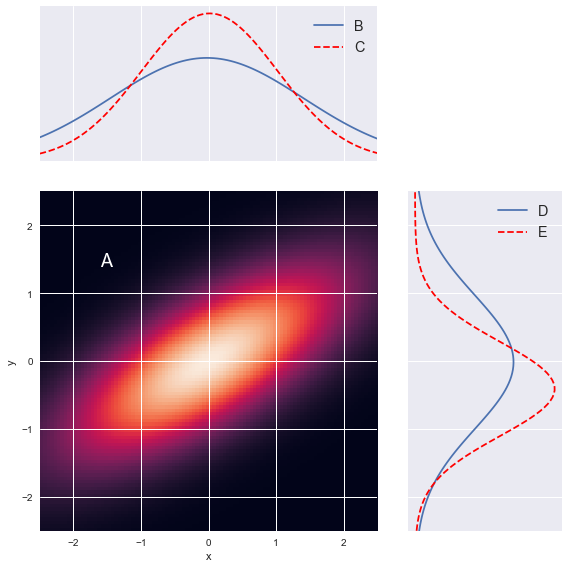

In [4]:
gen = np.random.RandomState(seed=123)
prob2d(gen.multivariate_normal([0,0], [[2,1],[1,1]], size=5000))

**EXERCISE:** The plot above shows probability densities in $x$ and $y$.
 - Write down the appropriate joint / marginal / conditional expressions for A-E.
 - How is each quantity A-E normalized?

Answer:
 - A is the joint PDF $f(x,y)$, normalized in 2D over $(x,y)$.
 - B is the marginal PDF $f(x)$, normalized in 1D over $x$.
 - C is the conditional PDF $f(x|y)$ with $y \simeq -0.7$, normalized in 1D over $x$.
 - D is the marginal PDF $f(y)$, normalized in 1D over $y$.
 - E is the conditional PDF $f(y|x)$ with $x \simeq 0.0$, , normalized in 1D over $y$.

We say that random variables $X$ and $Y$ are **independent** if
$$
F(x, y) = F(x) F(y) \; ,
$$
which leads to
$$
f(x, y) = f(x) f(y)
$$
and
$$
f(x\mid y) = f(x) \quad , \quad f(y\mid x) = f(y) \; .
$$
The corresponding picture is:

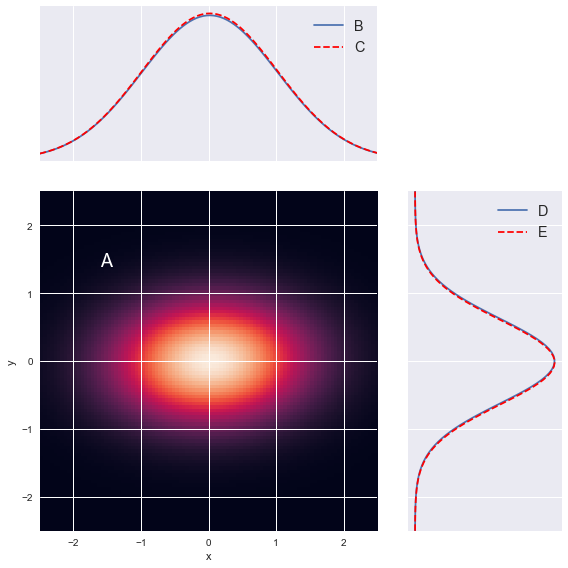

In [5]:
gen = np.random.RandomState(seed=123)
prob2d(gen.multivariate_normal([0,0], [[1,0],[0,0.4]], size=5000))

### Practical Probability Calculus

It is often useful to use probability densities that are hybrids of the fully joint / marginal / conditional cases, such as $f(x\mid y, z)$ and $f(x, y\mid z)$, but these do not require any new formalism.  In the following, we adopt a slightly more abstract notation with the following conventions:
 - $P(\ldots)$ is a generic probability (density).
 - $A_i$ and $B_j$ are generic random variables or, more generically, logical propositions about outcomes.
 - $D$ represents generic data features.
 - $\Theta$ represents generic model parameters.
 - $M$ represents generic model hyperparameters.

A practical calculus for such expressions boils down to the following transformation rules:

**Rule-1**: the order of arguments on either side of $\mid$ is not significant:
$$
P(A_1, A_2, \ldots\mid B_1, B_2\ldots) =
P(A_2, A_1, \ldots\mid B_1, B_2\ldots) =
P(A_1, A_2, \ldots\mid B_2, B_1\ldots) = \ldots
$$

**Rule-2**: use the definition of conditional probability to move a variable from the LHS to the RHS:
$$
P(A_2,\ldots\mid A_1,B_1,B_2,\ldots) = \frac{P(A_1,A_2,\ldots\mid B_1,B_2\ldots)}{P(A_1\mid B_1,B_2\ldots)} \; .
$$

**Rule-3**: use the chain rule to move a variable from the RHS to the LHS (really just a restatement of Rule-2):
$$
P(B_1,A_1,A_2,\ldots\mid B_2,\ldots) = P(A_1,A_2,\ldots\mid B_1,B_2,\ldots)\,P(B_1\mid B_2,\ldots) \; .
$$

**Rule-4**: use a marginalization integral to remove a variable from the LHS:
$$
P(A_2,\ldots\mid B_1,B_2,\ldots) = \int d A_1'\, P(A_1', A_2, \ldots\mid B_1, B_2\ldots) \; .
$$

**Rule-5**: combine Rule-3 and Rule-4 to remove a variable from the RHS:
$$
P(A_1,A_2,\ldots\mid B_2,\ldots) = \int d B_1'\, P(A_1,A_2,\ldots\mid B_1',B_2,\ldots)\,P(B_1'\mid B_2,\ldots) \; .
$$

**EXERCISE:** Use these rules to show that:
$$
P(\Theta_M \mid D,M) = \frac{P(D\mid\Theta_M ,M)\, P(\Theta_M,M)}{P(D,M)} \; .
$$
We will use this result later when we discuss Bayesian inference.

Apply the rules to the LHS in order to make it look more like the RHS:
$$
\begin{aligned}
P(\Theta_M \mid D,M) &= \frac{P(D,\Theta_M\mid M)}{P(D\mid M)} & \text{Rule-2} \\
&= \frac{P(D\mid\Theta_M,M)\,P(\Theta_M|M)}{P(D\mid M)} & \text{Rule-3} \\
&= \frac{P(D\mid\Theta_M,M)\left[ P(\Theta_M,M) / P(M)\right]}{\left[ P(D,M) / P(M)\right]} & \text{Rule-3} \\
&= \frac{P(D\mid\Theta_M,M)\, P(\Theta_M,M)}{P(D,M)} & \text{simplify}
\end{aligned}
$$